# Defect Detection and Synthetic Generation using MVTec AD dataset


In [32]:
# import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import random


In [20]:
# Step 2: Setup Paths and Select Categories

base_path = "E:/PROJECT"        
category = "bottle"
img_path = os.path.join(base_path, category)


Normal Images: 209
Defect Images: 83


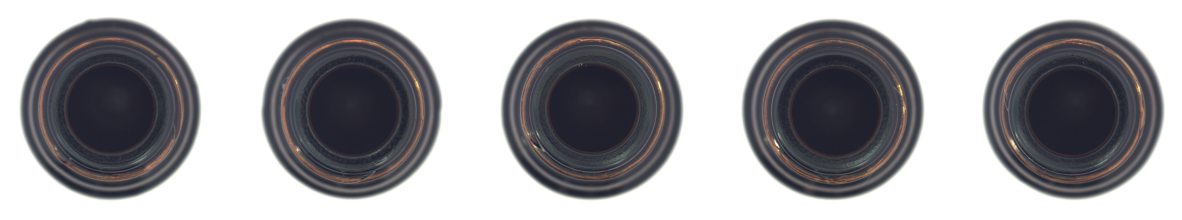

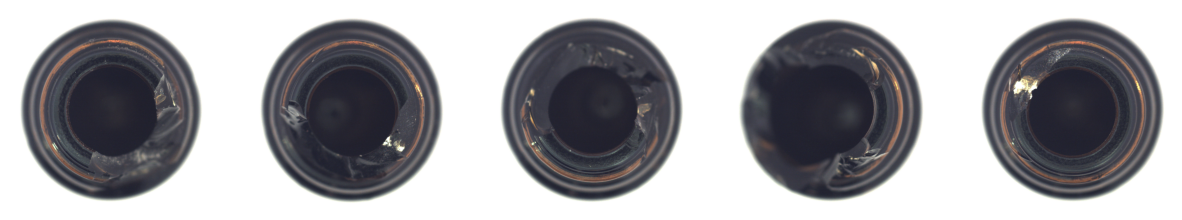

In [21]:
# Step 3: Visualize Sample Images
def show_images(img_list, n=5):
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(img_list[:n]):
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

normal_imgs = glob(os.path.join(img_path, "train/good", "*.png"))
defect_imgs = glob(os.path.join(img_path, "test", "*/", "*.png"))

print("Normal Images:", len(normal_imgs))
print("Defect Images:", len(defect_imgs))
show_images(normal_imgs)
show_images(defect_imgs)

In [22]:
# Step 4: Define Custom Dataset Loader
class MVTecDataset(Dataset):
    def __init__(self, img_files, transform=None):
        self.img_files = img_files
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label = 0 if "good" in img_path else 1
        return image, label

In [23]:
# Step 5: Data Augmentation and Loader
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_files, val_files = train_test_split(normal_imgs + defect_imgs, test_size=0.2, random_state=42)
train_dataset = MVTecDataset(train_files, transform=transform)
val_dataset = MVTecDataset(val_files, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [24]:
# Step 6: Define Simple CNN Classifier
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*32*32, 128), nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [25]:
# Step 7: Train the CNN
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.6225
Epoch 2, Loss: 0.5476
Epoch 3, Loss: 0.5501
Epoch 4, Loss: 0.5496
Epoch 5, Loss: 0.5280


In [26]:
# Step 8: Evaluate the CNN
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 83.05%


In [33]:
# Step 9: Synthetic Defect Generation using Albumentations
def generate_synthetic_defects(img_list, count=5):
    aug = A.Compose([
        A.ElasticTransform(p=1, alpha=1, sigma=50),
        A.RandomBrightnessContrast(p=1),
        A.GaussNoise(p=1)
    ])
    synthetic_imgs = []
    for img_file in random.sample(img_list, count):
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = aug(image=img)
        synthetic_imgs.append(augmented['image'])
    return synthetic_imgs


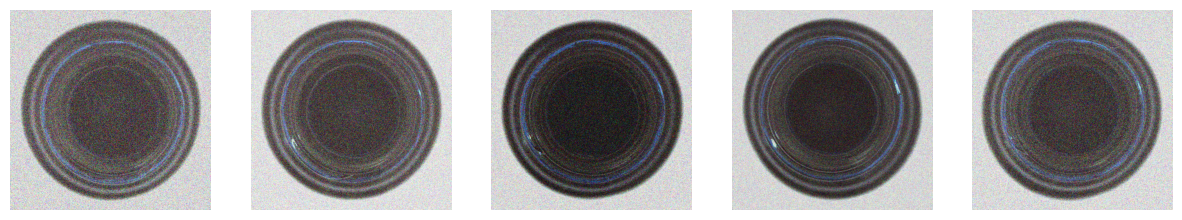

In [36]:
show_images([cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in synthetic_samples], n=5)


In [37]:
# Step 10: Integrate Synthetic Samples into Training

# Add synthetic images to the training dataset
def save_synthetic_samples(synthetic_samples, base_path="synthetic_images"):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    synthetic_files = []
    for idx, img in enumerate(synthetic_samples):
        file_name = os.path.join(base_path, f"synthetic_{idx}.jpg")
        cv2.imwrite(file_name, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        synthetic_files.append(file_name)
    return synthetic_files

synthetic_train_files = save_synthetic_samples(synthetic_samples)
augmented_train_files = train_files + synthetic_train_files
augmented_train_dataset = MVTecDataset(augmented_train_files, transform=transform)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)

In [38]:
# Step 11: Retrain the CNN with Augmented Dataset
for epoch in range(5):
    model.train()
    total_loss = 0
    for imgs, labels in augmented_train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(augmented_train_loader):.4f}")


Epoch 1, Loss: 0.5428
Epoch 2, Loss: 0.5415
Epoch 3, Loss: 0.5643
Epoch 4, Loss: 0.5242
Epoch 5, Loss: 0.4934


In [39]:
# Step 12: Final Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Validation Accuracy After Augmentation: {100 * correct / total:.2f}%")

Validation Accuracy After Augmentation: 83.05%
